# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

import torch
import torch.nn.functional as F
import botorch
import gpytorch

from src.selfies import SelfiesEncoder
from src.vae import MolecularVAE
from src.train import VAELoss, train_vae
from src.transforms import StandardScaler, UnitCubeScaler
from src.molecules import penalized_logp

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Preprocessing

Download raw dataset:

In [7]:
dataset_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

raw_df = pd.read_csv(dataset_url)
raw_df.to_csv(os.path.join("data", "qm9_raw.csv"), index=False)

Add selfies encoding to raw data:

In [9]:
df = pd.read_csv(os.path.join("data", "qm9_raw.csv"))

df["selfies"] = [sf.encoder(x, strict=False) for x in df.smiles]
df["penalized_logp"] = [penalized_logp(Chem.MolFromSmiles(s)) for s in df.smiles]
df = df[["mol_id", "smiles", "selfies", "penalized_logp"]]

df.to_csv(os.path.join("data", "qm9_processed.csv"), index=False)

Generate one-hot enocding for selfies strings:

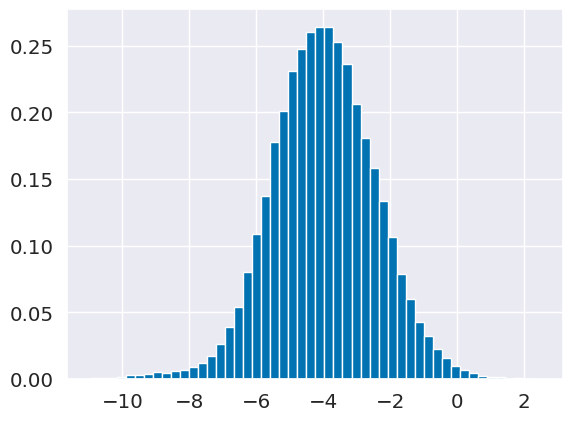

In [86]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))
df.penalized_logp.hist(bins=50, density=True)
plt.show()

In [11]:
selfies = df.selfies
selfies_encoder = SelfiesEncoder.build(selfies)

In [13]:
one_hots = []
for s in tqdm(selfies):
    one_hots.append(selfies_encoder.encode_one_hot(s))
one_hots = torch.tensor(one_hots)
torch.save(one_hots, os.path.join("data", "qm9_encodings.pt"))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [00:03<00:00, 37140.54it/s]


In [44]:
targets = torch.tensor(df.penalized_logp)
targets = targets.view(-1, 1)

torch.save(targets, os.path.join("data", "qm9_targets.pt"))

# VAE

## Training

In [222]:
torch.manual_seed(42)
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

x = torch.load(os.path.join("data", "qm9_encodings.pt"))
y = torch.load(os.path.join("data", "qm9_targets.pt"))
x = x.float().to(device)
y = y.float().to(device)

full_dataset =  torch.utils.data.TensorDataset(x, y)

test_frac = 0.1
test_size = int(test_frac * len(x))
train_size = len(x) - test_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [223]:
batch_size = 250

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [224]:
latent_size = 100
model = MolecularVAE(latent_size=latent_size)
model.to(device)

print(f"# Parameters = {model.n_parameters()}")
model

# Parameters = 4171136


MolecularVAE(
  (encoder_conv): Sequential(
    (0): Conv1d(29, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(9, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(9, 10, kernel_size=(10,), stride=(1,), padding=(2,))
    (5): ReLU()
  )
  (encoder_linear): Sequential(
    (0): Linear(in_features=80, out_features=400, bias=True)
    (1): SELU()
  )
  (encoder_mean): Linear(in_features=400, out_features=100, bias=True)
  (encoder_logvar): Linear(in_features=400, out_features=100, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): SELU()
  )
  (decoder_gru): GRU(100, 500, num_layers=3, batch_first=True)
  (decoder_output): Linear(in_features=500, out_features=29, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(i

In [225]:
include_mse = True
criterion = VAELoss(include_mse = include_mse)

learning_rate = 2e-3
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-5 ,
)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[15, 30, 50, 70, 90], 
    gamma=0.5
)


In [226]:
n_epochs = 100
tracker = train_vae(
    model, 
    criterion,
    optimizer, 
    scheduler,
    train_loader, 
    test_loader,
    n_epochs=n_epochs,
    print_every=1
)

1 | train_elbo = 26.648 | test_elbo = 21.468 | train_mse = 1.087 | test_mse = 0.488 | train_accuracy = 0.000 | test_accuracy = 0.000
2 | train_elbo = 20.222 | test_elbo = 17.561 | train_mse = 0.426 | test_mse = 0.459 | train_accuracy = 0.000 | test_accuracy = 0.001
3 | train_elbo = 16.672 | test_elbo = 13.509 | train_mse = 0.445 | test_mse = 0.368 | train_accuracy = 0.001 | test_accuracy = 0.004
4 | train_elbo = 12.707 | test_elbo = 11.027 | train_mse = 0.420 | test_mse = 0.495 | train_accuracy = 0.007 | test_accuracy = 0.018
5 | train_elbo = 10.057 | test_elbo = 8.758 | train_mse = 0.396 | test_mse = 0.380 | train_accuracy = 0.028 | test_accuracy = 0.046
6 | train_elbo = 8.024 | test_elbo = 6.552 | train_mse = 0.378 | test_mse = 0.335 | train_accuracy = 0.066 | test_accuracy = 0.118
7 | train_elbo = 6.806 | test_elbo = 6.131 | train_mse = 0.360 | test_mse = 0.338 | train_accuracy = 0.114 | test_accuracy = 0.148
8 | train_elbo = 5.856 | test_elbo = 4.848 | train_mse = 0.339 | test_mse 

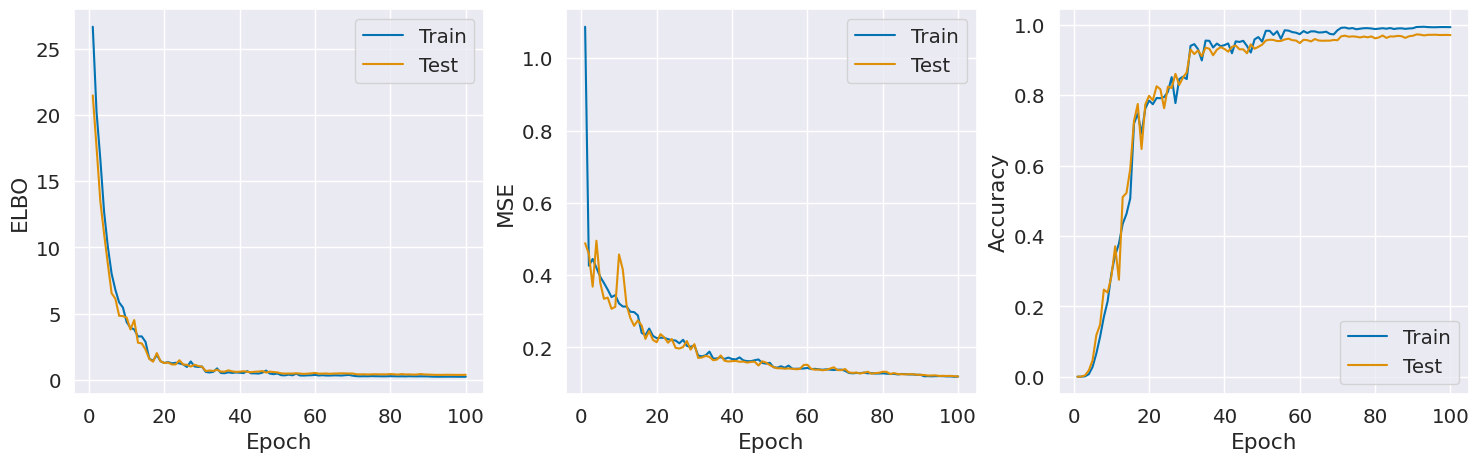

In [227]:
_, ax = plt.subplots(1, 3, figsize=(18, 5))

train_elbo = tracker.get("train_elbo")
test_elbo = tracker.get("test_elbo")

train_mse = tracker.get("train_mse")
test_mse = tracker.get("test_mse")

train_accuracy = tracker.get("train_accuracy")
test_accuracy = tracker.get("test_accuracy")

ax[0].plot(train_elbo[:,0], train_elbo[:,1], label='Train')
ax[0].plot(test_elbo[:,0], test_elbo[:,1], label='Test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('ELBO')
ax[0].legend()

ax[1].plot(train_mse[:,0], train_mse[:,1], label='Train')
ax[1].plot(test_mse[:,0], test_mse[:,1], label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].legend()

ax[2].plot(train_accuracy[:,0], train_accuracy[:,1], label='Train')
ax[2].plot(test_accuracy[:,0], test_accuracy[:,1], label='Test')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].legend()

# plt.savefig(os.path.join("images", f"vae_latent_{latent_size}_mse_{include_mse}.png"))
plt.show()

In [228]:
# torch.save(model.state_dict(), os.path.join("models", f"vae_latent_{latent_size}_mse_{include_mse}.pt"))

## Characterization

In [229]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

selfies = list(df.selfies)
selfies_encoder = SelfiesEncoder.build(selfies)

In [230]:
latent_size = 100
vae_params = torch.load(os.path.join("models", f"vae_latent_{latent_size}_mse_True.pt"))

vae = MolecularVAE(latent_size=latent_size)
vae.load_state_dict(vae_params)

vae.eval()

MolecularVAE(
  (encoder_conv): Sequential(
    (0): Conv1d(29, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(9, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(9, 10, kernel_size=(10,), stride=(1,), padding=(2,))
    (5): ReLU()
  )
  (encoder_linear): Sequential(
    (0): Linear(in_features=80, out_features=400, bias=True)
    (1): SELU()
  )
  (encoder_mean): Linear(in_features=400, out_features=100, bias=True)
  (encoder_logvar): Linear(in_features=400, out_features=100, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): SELU()
  )
  (decoder_gru): GRU(100, 500, num_layers=3, batch_first=True)
  (decoder_output): Linear(in_features=500, out_features=29, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(i

In [235]:
start_selfie = sf.encoder("C")
end_selfie = sf.encoder("CC(=O)OC1=CC=CC=C1")
end_selfie = '[C][Branch1][Ring2][C][C][=O][C][O]'

start_x = torch.tensor(selfies_encoder.encode_one_hot(start_selfie), dtype=torch.float32)
end_x = torch.tensor(selfies_encoder.encode_one_hot(end_selfie), dtype=torch.float32)

interp_x = vae.interpolate(start_x, end_x, 5)
interp_x = interp_x

interp_selfies = [start_selfie] + [selfies_encoder.decode_tensor(x) for x in interp_x] + [end_selfie]
interp_mols = [Chem.MolFromSmiles(sf.decoder(s)) for s in interp_selfies]

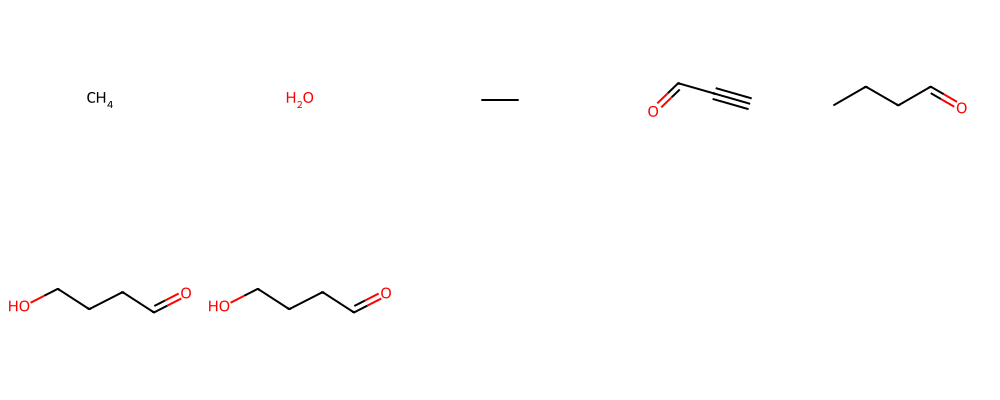

In [236]:
Chem.Draw.MolsToGridImage(interp_mols, molsPerRow=5)

### Regression

In [237]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

import umap

torch.manual_seed(145);

In [238]:
x_sample = torch.load(os.path.join("data", "qm9_encodings.pt"))
y_sample = torch.load(os.path.join("data", "qm9_targets.pt"))

sample_indices = torch.randperm(x_sample.shape[0])

x_sample = x_sample[sample_indices]
y_sample = y_sample[sample_indices]

x_sample = x_sample[::50].float()
y_sample = y_sample[::50].float()

x_sample.shape

torch.Size([2678, 21, 29])

In [239]:
selfies_sample = [selfies_encoder.decode_tensor(xi) for xi in x_sample]
mols_sample = [Chem.MolFromSmiles(sf.decoder(s)) for s in selfies_sample]

In [240]:
z = vae.encode(x_sample)[0].detach().double()

y = torch.tensor(targets_sample).view(-1, 1).double()

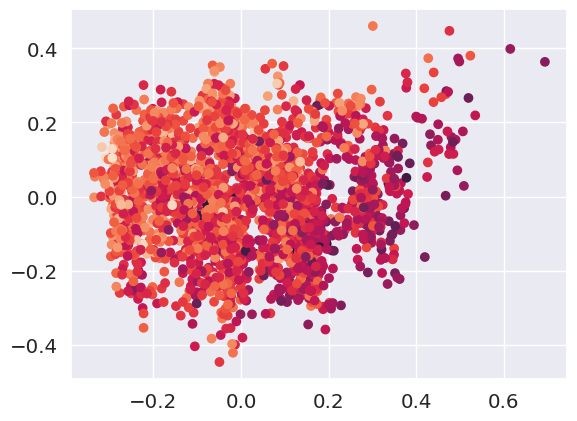

In [242]:
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=y)
plt.show()

In [243]:
indices = torch.randperm(z.shape[0])

n_train = 1000

ind_train = indices[:n_train]
ind_test = indices[n_train:]

z_train = z[ind_train]
z_test = z[ind_test]

y_train = y[ind_train]
y_test = y[ind_test]

input_scaler = UnitCubeScaler.build(z_train)
z_train_scaled = input_scaler.transform(z_train)
z_test_scaled = input_scaler.transform(z_test)

output_scaler = StandardScaler.build(y_train)
y_train_scaled = output_scaler.transform(y_train)
y_test_scaled = output_scaler.transform(y_test)

In [244]:
gp = SingleTaskGP(z_train_scaled, y_train_scaled)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

In [245]:
mll = fit_gpytorch_mll(mll)

In [246]:
mvn = gp(z_test_scaled)

y_pred_mean = mvn.mean.detach()

In [247]:
r2_score(y_test_scaled, y_pred_mean)

0.8175964436180242

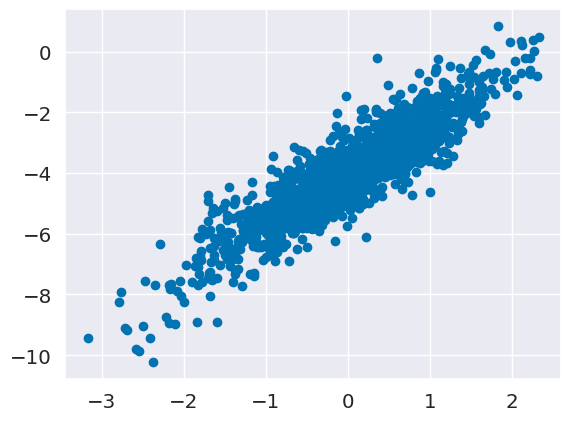

In [248]:
plt.scatter(y_pred_mean, y_test.flatten())

plt.show()